# Details on the kaggle competition

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge


In [50]:
# Import libraries necessary for this project

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
    
import numpy as np
import pandas as pd
from time import time
from keras.utils import np_utils

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import TweetTokenizer # doesn't split at apostrophes
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from collections import Counter

%matplotlib inline 

In [47]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/anveshtummala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/anveshtummala/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [23]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

submission = pd.read_csv('input/sample_submission.csv')

# 1. Peak on the input datasets

In [24]:
print("## train_data:")
train[train.severe_toxic > 0].head(2)

## train_data:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0


In [25]:
print("## test_data:")
test.head(2)

## test_data:


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...


In [26]:
print("## submission_data:")
submission.head(2)

## submission_data:


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5


# 2. Do stats on the data like count 

In [27]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
test.describe()

,id,comment_text
count,153164,153164
unique,153164,153164
top,cd474ab072429e88,::Someone keeps reverting to an error. Aristo...
freq,1,1


In [29]:
submission.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,153164.0,153164.0,153164.0,153164.0,153164.0,153164.0
mean,0.5,0.5,0.5,0.5,0.5,0.5
std,0.0,0.0,0.0,0.0,0.0,0.0
min,0.5,0.5,0.5,0.5,0.5,0.5
25%,0.5,0.5,0.5,0.5,0.5,0.5
50%,0.5,0.5,0.5,0.5,0.5,0.5
75%,0.5,0.5,0.5,0.5,0.5,0.5
max,0.5,0.5,0.5,0.5,0.5,0.5


# 3. Check for missing data

In [30]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
identity_hate,0,0.0
insult,0,0.0
threat,0,0.0
obscene,0,0.0
severe_toxic,0,0.0
toxic,0,0.0
comment_text,0,0.0
id,0,0.0



Luckly, we dont have any missing data. so we dont need to fill null values.
It is also good to verify null values on test, submission data, found there is no missing values in them.


# 4. Data analysis on training set

## 4.1 Distribution of toxic-comment-category 

In [31]:
display(train.toxic.value_counts())
display(train.severe_toxic.value_counts())
display(train.obscene.value_counts())
display(train.threat.value_counts())
display(train.insult.value_counts())
display(train.identity_hate.value_counts())
#sns.countplot(x="toxic", data=train, orient='v');

0    144277
1     15294
Name: toxic, dtype: int64

0    157976
1      1595
Name: severe_toxic, dtype: int64

0    151122
1      8449
Name: obscene, dtype: int64

0    159093
1       478
Name: threat, dtype: int64

0    151694
1      7877
Name: insult, dtype: int64

0    158166
1      1405
Name: identity_hate, dtype: int64

 (0, 159571),

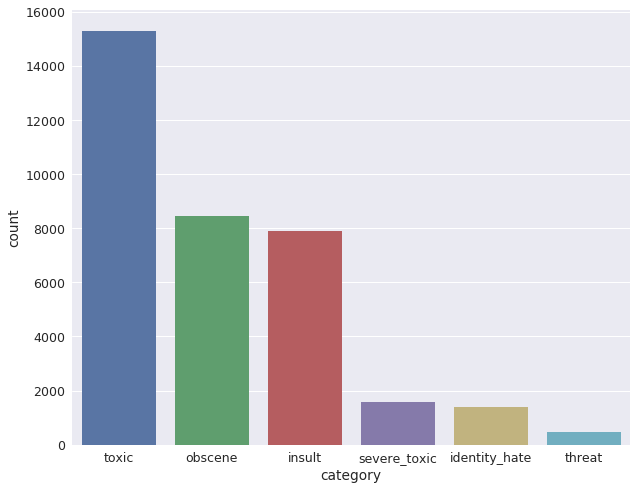

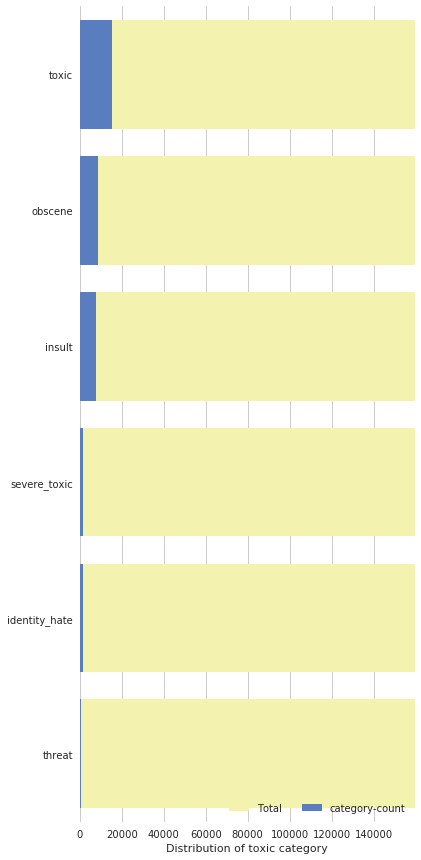

In [32]:
d = {'category' : ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], 
     'count' : [15294, 1595, 8449, 478, 7877, 1405],
     'total' : [159571, 159571, 159571, 159571, 159571, 159571]
    }
train_value_counts = pd.DataFrame(d).sort_values("count", ascending=False)

plt.rcParams["figure.figsize"] = [10,8]
sns.barplot(x="category", y="count", data=train_value_counts, );

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total comments
sns.set_color_codes("pastel")
sns.barplot(x="total", y="category", data=train_value_counts,
            label="Total", color="y")

# Plot the toxic comments per category
sns.set_color_codes("muted")
sns.barplot(x="count", y="category", data=train_value_counts,
            label="category-count", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right")
ax.set(xlim=(0, 159571), ylabel="",
       xlabel="Distribution of toxic category")
sns.despine(left=True, bottom=True)

## 4.2 comments with one/all toxic-comment-category

Lets observe really bad comments, that is if all catrgories are true.

In [33]:
train_reallybad = train[(train.toxic>0) & (train.severe_toxic>0) & (train.obscene>0)
                        & (train.threat>0) & (train.insult>0) & (train.identity_hate>0)]
train_reallybad.head(2)
print(train_reallybad [train_reallybad.id == '02c6e41e4b317ac3'].comment_text)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1017,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1
1312,039296aa294ee10b,"SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!",1,1,1,1,1,1


1017    WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...
Name: comment_text, dtype: object


In [34]:
train_bad = train[(train.toxic>0) | (train.severe_toxic>0) | (train.obscene>0)
                        | (train.threat>0) | (train.insult>0) | (train.identity_hate>0)]
train_bad.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0


In [35]:
print(len(train_bad))
print(len(train_reallybad))    

16225
31


**Out of 159571 comments there are:**
* **16225** comments that are bad **toxic | severe_toxic | obscene | threat | insult | identity_hate**
* **31** comments that are very bad **toxic & severe_toxic & obscene & threat & insult & identity_hate**

## 4.3 Correlation among catgories

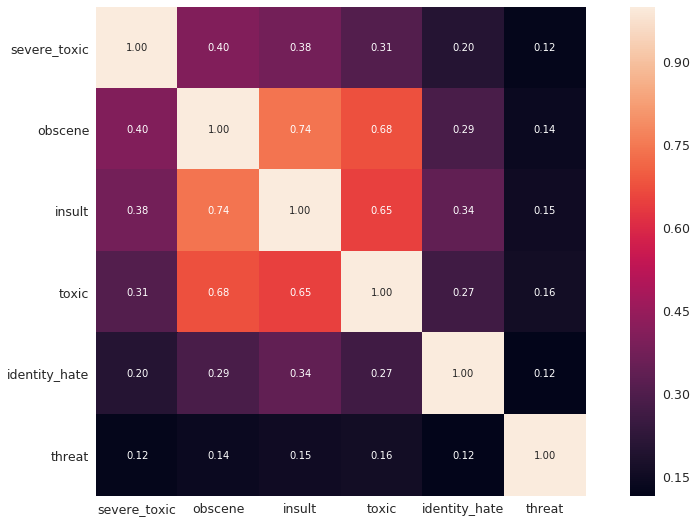

CPU times: user 500 ms, sys: 20.2 ms, total: 520 ms
Wall time: 517 ms


In [36]:
%%time
#correlation matrix
corrmat = train.corr()
plt.rcParams["figure.figsize"] = [16,9]
cols = corrmat.nlargest(10, 'severe_toxic')['severe_toxic'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

From the heatmap, there is an high correlation among obscene, insult, toxic comments

## 4.4 Percentage of Intersection of two catgories ~ Correlation value ??

Lets try out by considering 2 categories (obscene, insult)

In [37]:
#ax = sns.tsplot(data=train, estimator=np.median)
np.logical_and(train['obscene'], train['insult']).value_counts()

False    153416
True       6155
Name: obscene, dtype: int64

Total obscene comments: **8449**   
Total insult comments: **7877**   
Total obscene and insult comments: **6155**

Percentage of obscene comments that are also insult comments: 6155/8449 = 72.8%    
Percentage of insult comments that are also obscene comments: 6155/7877 = 78.1%     
The correlation value of 74 among obscene and insult looks like an average value of 72, 78.

**So, We can use correlation value as a measure of intersection among 2 categories.**

## 5 Data analysis

## 5.1 Length of comments, word count 

In [38]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.07322132467681, 590.72028190489186, 5000)

In [39]:
lens = test.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(364.87512078556318, 592.49209873027792, 5000)

In [40]:
words = (train.comment_text.str.count(' ')  + train.comment_text.str.count('\n'))
words.mean(), words.std(), words.max()

(69.387702026057369, 104.11176019153748, 2319)

In [41]:
words = (test.comment_text.str.count(' ')  + train.comment_text.str.count('\n'))
words.mean(), words.std(), words.max()


(66.955707607531792, 106.8467131703389, 2833.0)

In [52]:
def digin(column_name):
    
    toxic_comnts = train[train[column_name]==1]['comment_text']
    toxic_comnts = toxic_comnts[:20000]                                          # reduce comments size due to memory limitations
    t_tokenized_sents = [word_tokenize(sentences) for sentences in toxic_comnts] # create sentences
    t_tagged = [pos_tag(words) for words in t_tokenized_sents]                   # create tags for each token
    
    t_categories = [y for lists in t_tagged for x,y in lists]                    # extract tags
    t_counting_catg = Counter(t_categories) 
    
    df = pd.DataFrame.from_dict(t_counting_catg, orient='index').reset_index()
    df.columns=('category','amount')
    df = df.sort_values(by='amount', ascending=False)
    df = df[:15]                                                                 # limit to the top 15 highest counts of taggs
    df['%'] = df['amount']/ df['amount'].sum(axis=0)                             # calculate percentage

    sns.barplot(x='category', y='%', data=df)            
    plt.title("% of the time a tag appears in " + column_name + " comments")
    fig=plt.gcf()
    fig.set_size_inches(10,5)
    plt.show()


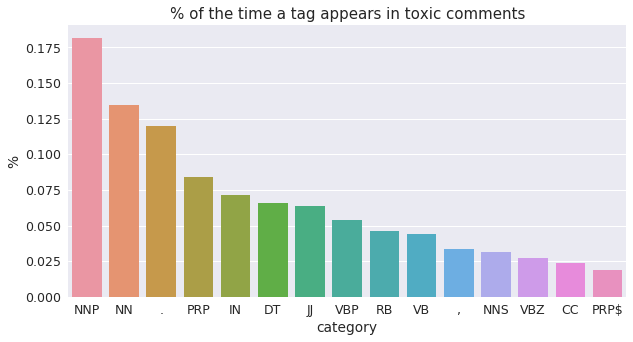

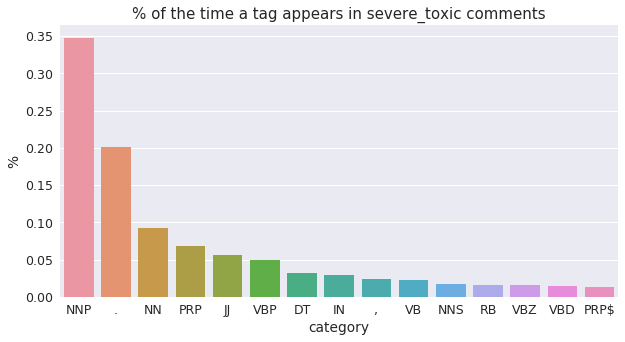

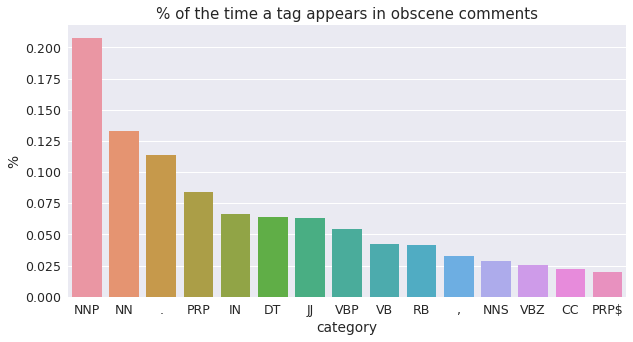

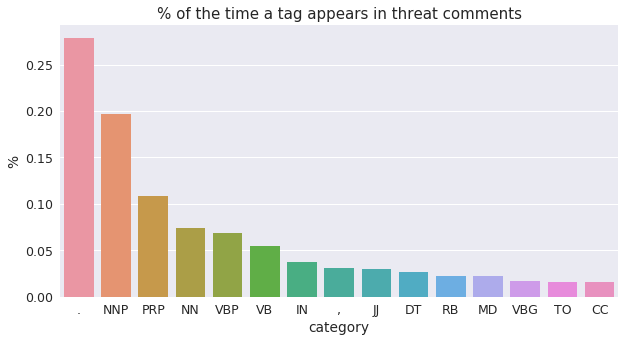

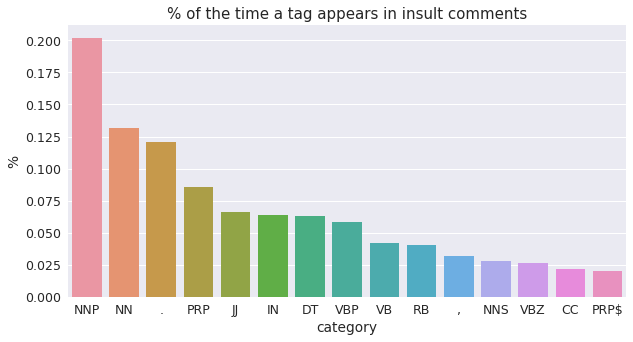

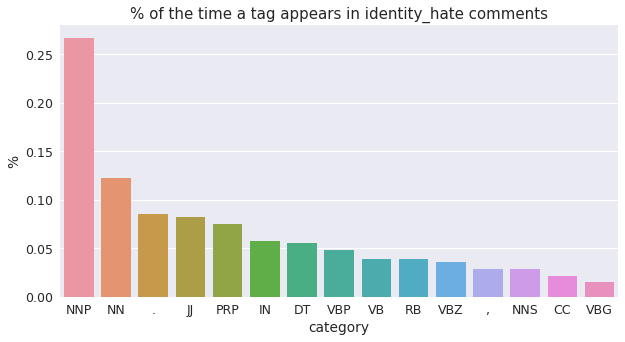

In [55]:
columnList = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for col in columnList:
    digin(col)


In [54]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [58]:
def parts_of_speech():
    
    toxic_comnts = train[(train.toxic>0) | (train.severe_toxic>0) | (train.obscene>0)
                        | (train.threat>0) | (train.insult>0) | (train.identity_hate>0)]['comment_text']
    
    t_tokenized_sents = [word_tokenize(sentences) for sentences in toxic_comnts] # create sentences
    t_tagged = [pos_tag(words) for words in t_tokenized_sents]                   # create tags for each token
    
    t_categories = [y for lists in t_tagged for x,y in lists]                    # extract tags
    t_counting_catg = Counter(t_categories) 
    
    df = pd.DataFrame.from_dict(t_counting_catg, orient='index').reset_index()
    df.columns=('category','amount')
    df = df.sort_values(by='amount', ascending=False)
    df = df[:15]                                                                 # limit to the top 15 highest counts of taggs
    df['%'] = df['amount']/ df['amount'].sum(axis=0)                             # calculate percentage

    sns.barplot(x='category', y='%', data=df)            
    plt.title("% of the time a tag appears in all toxic comments")
    fig=plt.gcf()
    fig.set_size_inches(10,5)
    plt.show()

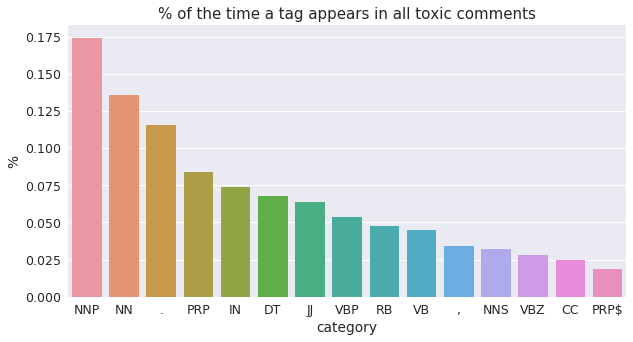

In [59]:
parts_of_speech()

In [62]:
def parts_of_speech_nontoxic():
    
    toxic_comnts = train[((train.toxic>0) | (train.severe_toxic>0) | (train.obscene>0)
                        | (train.threat>0) | (train.insult>0) | (train.identity_hate>0)) == False]['comment_text']
    
    t_tokenized_sents = [word_tokenize(sentences) for sentences in toxic_comnts] # create sentences
    t_tagged = [pos_tag(words) for words in t_tokenized_sents]                   # create tags for each token
    
    t_categories = [y for lists in t_tagged for x,y in lists]                    # extract tags
    t_counting_catg = Counter(t_categories) 
    
    df = pd.DataFrame.from_dict(t_counting_catg, orient='index').reset_index()
    df.columns=('category','amount')
    df = df.sort_values(by='amount', ascending=False)
    df = df[:15]                                                                 # limit to the top 15 highest counts of taggs
    df['%'] = df['amount']/ df['amount'].sum(axis=0)                             # calculate percentage

    sns.barplot(x='category', y='%', data=df)            
    plt.title("% of the time a tag appears in non-toxic comments")
    fig=plt.gcf()
    fig.set_size_inches(10,5)
    plt.show()
    

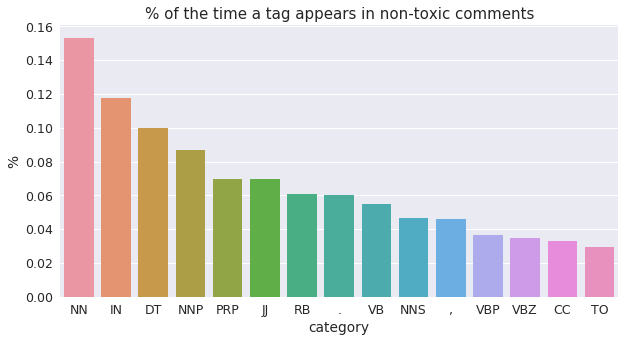

In [61]:
parts_of_speech_nontoxic()